Epoch [10/1000], Loss: 7.7587
Epoch [20/1000], Loss: 3.3756
Epoch [30/1000], Loss: 3.0168
Epoch [40/1000], Loss: 2.7049
Epoch [50/1000], Loss: 2.4053
Epoch [60/1000], Loss: 2.1984
Epoch [70/1000], Loss: 2.0178
Epoch [80/1000], Loss: 1.8620
Epoch [90/1000], Loss: 1.7324
Epoch [100/1000], Loss: 1.6835
Epoch [110/1000], Loss: 1.5277
Epoch [120/1000], Loss: 1.3912
Epoch [130/1000], Loss: 1.3371
Epoch [140/1000], Loss: 1.2483
Epoch [150/1000], Loss: 1.1682
Epoch [160/1000], Loss: 1.0908
Epoch [170/1000], Loss: 1.0410
Epoch [180/1000], Loss: 1.0640
Epoch [190/1000], Loss: 0.9987
Epoch [200/1000], Loss: 0.9714
Epoch [210/1000], Loss: 0.8711
Epoch [220/1000], Loss: 0.9888
Epoch [230/1000], Loss: 0.8226
Epoch [240/1000], Loss: 0.8575
Epoch [250/1000], Loss: 0.7671
Epoch [260/1000], Loss: 1.1068
Epoch [270/1000], Loss: 0.9060
Epoch [280/1000], Loss: 0.7925
Epoch [290/1000], Loss: 0.7287
Epoch [300/1000], Loss: 0.7027
Epoch [310/1000], Loss: 0.6737
Epoch [320/1000], Loss: 0.7323
Epoch [330/1000],

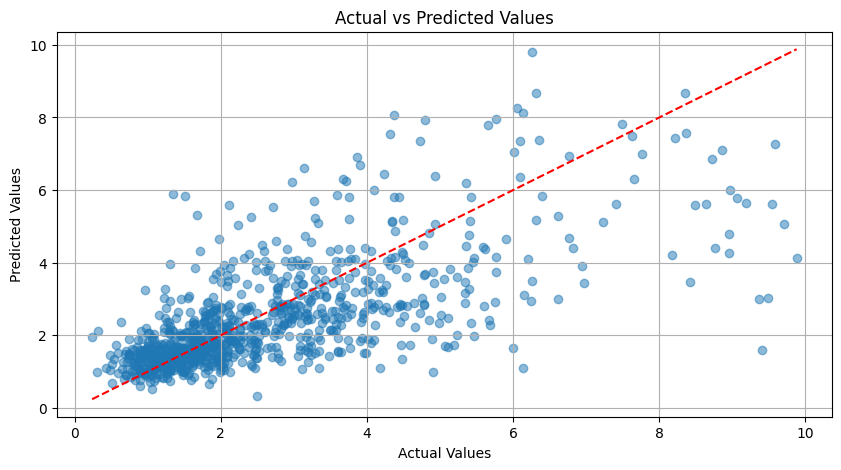

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

# Extract features and target
X1 = data.drop(columns=[target]).values
y1 = data[target].values

# Create a boolean mask where y values are <= 10
mask = y1 <= 10

# Apply mask to filter X and y
X = X1[mask]
y = y1[mask]

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Apply Savitzky-Golay filter
X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=1, delta=2)

# Apply SNV transformation
X_snv = standard_normal_variate(X_sg)

# Apply PCA before scaling
pca = PCA()
X_pca = pca.fit_transform(X_snv)




# Normalize features
scaler = StandardScaler()

#X_pca_scaled = scaler.fit_transform(X)


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]  # Number of features after PCA and scaling
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 1000
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()